## Fraud Analysis for NYC property Data
#### Xiangyu Huang


**Abstract:** 

In this project, I will analyze the NYC property data, build 'expert' varaibles and give fraud scores to NYC property data. At the end, I will list the top suspicious fraud properties.

**Data Set Information:**

“Property Valuation and Assessment Data” was published on New York City Open Data by the Department of Finance (DOF). This dataset was created on Sept 2nd, 2011, and its most recent update happened on Sep 10th, 2018. In this dataset, there are 31 fields as columns in total. Among these fields, 14 of them are numerical variables, 16 of them are categorical fields and one of the fields is datetime data. This report will evaluate all these fields and examines the quality of the dataset for further analysis. 

**Fraud Analysis**

In this project, I will calculate two fraud scores and combine to find the suspicious property. I will first build 'expert varaibles' as instructed. Then, I will standardize all the variables for implmentation of PCA. With the PCA, I will keep 7 PCs and calculate two scores. The first score is based on euclidean distance of PC results from the origins to detect extreme results. The second score is based on the distance between autoencoder results of each record and the record itselft.

In [39]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from re import search
from datetime import datetime
from sklearn.neural_network import MLPRegressor
import scipy.stats as sps
from sklearn.decomposition import PCA

In [40]:
data = pd.read_csv('NY property data.csv')
data = data[['BORO','OWNER', 'ZIP', 'TAXCLASS', 'STORIES' ,'FULLVAL', 'AVLAND', 'AVTOT', 'LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH']]

In [41]:
data['OWNER'] = data['OWNER'].str.upper()

In [42]:
data = data[data['OWNER'].str.contains(r"DEPT|NYC|NEW YOR|ASSOC|U S|DEPARTMENT|RECREATION|FEDERAL|PUBLIC|SERV|NYS|UNITED") == False]

In [43]:
data

,BORO,OWNER,ZIP,TAXCLASS,STORIES,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,BLDFRONT,BLDDEPTH
8,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,3944762,636093,1775143,0,0,0,0
9,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,5700930,919276,2565419,0,0,0,0
10,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,10600000,967500,4770000,0,0,0,0
11,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,1011928,163174,455368,0,0,0,0
12,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,2318026,373783,1043112,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5,GRACE G BUONO,10312.0,1,2.0,275100,9341,14042,24,70,24,24
1048571,5,WALTER ACIERTO,10312.0,1,2.0,275100,9341,14042,24,70,24,24
1048572,5,RICHARD P. DEVLIN,10312.0,1,2.0,257000,7981,12820,18,70,18,28
1048573,5,LLERENA ROCIO A,10312.0,1,2.0,257000,7981,12820,18,70,18,28


In [6]:
## Fill up the ZIP values by ffill since the data is already sorted by ZIP
data['ZIP'].fillna(method = 'ffill', inplace = True)
sum(data['ZIP'].isna())

0

In [7]:
## Clean up the NA Stores by replacing with the subgroup TAXCLASS mean
mean_stores = data.groupby('TAXCLASS')['STORIES'].mean()
for each_mean in mean_stores.index:
    data.loc[(data['STORIES'].isnull() == True) & (data['TAXCLASS'] == each_mean), 'STORIES'] = mean_stores[each_mean]
sum(data['STORIES'].isnull())

0

In [8]:

data.loc[data['FULLVAL'] == 0, 'FULLVAL'] = np.nan 
data.loc[data['AVLAND'] == 0 , 'AVLAND'] = np.nan 
data.loc[data['AVTOT'] == 0 , 'AVTOT'] = np.nan 
data.loc[data['LTFRONT']==0,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==0,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==0,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==0,'BLDDEPTH']=np.nan
data.loc[data['LTFRONT']==1,'LTFRONT']=np.nan
data.loc[data['LTDEPTH']==1,'LTDEPTH']=np.nan
data.loc[data['BLDFRONT']==1,'BLDFRONT']=np.nan
data.loc[data['BLDDEPTH']==1,'BLDDEPTH']=np.nan

# Calculate mean now (mean function ignores NAs but not 0s hence we converted 0 to NA)
mean_fullv = data.groupby('TAXCLASS')['FULLVAL'].mean()
mean_avland = data.groupby('TAXCLASS')['AVLAND'].mean()
mean_avtot = data.groupby('TAXCLASS')['AVTOT'].mean()
mean_ltfront =data.groupby(data['TAXCLASS'])['LTFRONT'].mean()
mean_ltdepth=data.groupby(data['TAXCLASS'])['LTDEPTH'].mean()
mean_bldfront =data.groupby(data['TAXCLASS'])['BLDFRONT'].mean()
mean_blddepth=data.groupby(data['TAXCLASS'])['BLDDEPTH'].mean()

for index in mean_fullv.index:
    data.loc[(data['FULLVAL'].isnull()) & (data['TAXCLASS'] == index), 'FULLVAL'] = mean_fullv[index]
    data.loc[(data['AVLAND'].isnull()) & (data['TAXCLASS'] == index), 'AVLAND'] = mean_avland[index]
    data.loc[(data['AVTOT'].isnull()) & (data['TAXCLASS'] == index), 'AVTOT'] = mean_avtot[index]
    data.loc[(data['LTFRONT'].isnull())&(data['TAXCLASS']==index),'LTFRONT']=mean_ltfront[index]    
    data.loc[(data['LTDEPTH'].isnull())&(data['TAXCLASS']==index),'LTDEPTH']=mean_ltdepth[index]
    data.loc[(data['BLDFRONT'].isnull())&(data['TAXCLASS']==index),'BLDFRONT']=mean_bldfront[index]
    data.loc[(data['BLDDEPTH'].isnull())&(data['TAXCLASS']==index),'BLDDEPTH']=mean_blddepth[index]

In [9]:
sum(data['FULLVAL'].isnull())

0

In [10]:
sum(data['FULLVAL'].isna())

0

In [11]:
mean_fullv

TAXCLASS
1     5.701834e+05
1A    3.381727e+05
1B    3.497902e+05
1C    6.343223e+05
1D    2.233614e+07
2     8.043556e+05
2A    8.571669e+05
2B    1.244281e+06
2C    8.176028e+05
3     1.219301e+05
4     2.861189e+06
Name: FULLVAL, dtype: float64

In [12]:
data['ZIP'] = data['ZIP'].astype(str)

In [13]:
data['zip3'] = data['ZIP'].str[:3]

In [14]:
data['ltsize'] = data['LTFRONT'] * data['LTDEPTH']
data['bldsize'] = data['BLDFRONT'] * data['BLDDEPTH']
data['bldvol'] = data['bldsize'] * data['STORIES']

In [15]:
data['r1'] = data['FULLVAL'] / data['ltsize']
data['r2'] = data['FULLVAL'] / data['bldsize']
data['r3'] = data['FULLVAL'] / data['bldvol']
data['r4'] = data['AVLAND'] / data['ltsize']
data['r5'] = data['AVLAND'] / data['bldsize']
data['r6'] = data['AVLAND'] / data['bldvol']
data['r7'] = data['AVTOT'] / data['ltsize']
data['r8'] = data['AVTOT'] / data['bldsize']
data['r9'] = data['AVTOT'] / data['bldvol']

In [16]:
nine_ratios = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7' ,'r8', 'r9']
zip5_mean = data.groupby('ZIP')[nine_ratios].mean()
zip3_mean = data.groupby('zip3')[nine_ratios].mean()
taxclass_mean = data.groupby('TAXCLASS')[nine_ratios].mean()
borough_mean = data.groupby('BORO')[nine_ratios].mean()


In [17]:
data = data.join(zip5_mean, on = 'ZIP', rsuffix = '_zip5')
data = data.join(zip3_mean, on = 'zip3', rsuffix = '_zip3')
data = data.join(taxclass_mean, on = 'TAXCLASS', rsuffix = '_taxclass')
data = data.join(borough_mean, on = 'BORO', rsuffix = '_boro')
rsuffix = ['_zip5', '_zip3', '_taxclass', '_boro']

In [18]:
for var in nine_ratios:
    for r in rsuffix:
        data[str(var) + r] = data[var] / data[str(var) + r]
data

,BORO,OWNER,ZIP,TAXCLASS,STORIES,FULLVAL,AVLAND,AVTOT,LTFRONT,LTDEPTH,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
8,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,3944762.0,636093.0,1775143.0,82.416468,123.791843,...,0.090573,1.053304,1.359031,0.123078,1.861520,2.322405,0.210200,1.908852,2.552954,0.291612
9,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,5700930.0,919276.0,2565419.0,82.416468,123.791843,...,0.130895,1.522224,1.964058,0.177871,2.690253,3.356320,0.303778,2.758654,3.689504,0.421434
10,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,10600000.0,967500.0,4770000.0,82.416468,123.791843,...,0.243379,2.830341,3.651863,0.330723,2.831380,3.532388,0.319714,5.129290,6.860062,0.783592
11,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,1011928.0,163174.0,455368.0,82.416468,123.791843,...,0.023234,0.270198,0.348625,0.031572,0.477527,0.595756,0.053922,0.489668,0.654896,0.074806
12,1,"TRZ HOLDINGS, LLC",10004.0,4,50.0,2318026.0,373783.0,1043112.0,82.416468,123.791843,...,0.053223,0.618944,0.798596,0.072323,1.093872,1.364699,0.123518,1.121682,1.500171,0.171357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,5,GRACE G BUONO,10312.0,1,2.0,275100.0,9341.0,14042.0,24.000000,70.000000,...,0.840373,1.292942,1.018674,0.925400,1.215594,0.894267,0.796782,0.941883,0.785924,0.692851
1048571,5,WALTER ACIERTO,10312.0,1,2.0,275100.0,9341.0,14042.0,24.000000,70.000000,...,0.840373,1.292942,1.018674,0.925400,1.215594,0.894267,0.796782,0.941883,0.785924,0.692851
1048572,5,RICHARD P. DEVLIN,10312.0,1,2.0,257000.0,7981.0,12820.0,18.000000,70.000000,...,0.876845,1.610498,1.087601,0.988016,1.384813,0.873218,0.778029,1.146554,0.820033,0.722921
1048573,5,LLERENA ROCIO A,10312.0,1,2.0,257000.0,7981.0,12820.0,18.000000,70.000000,...,0.876845,1.610498,1.087601,0.988016,1.384813,0.873218,0.778029,1.146554,0.820033,0.722921


In [19]:
data.columns

Index(['BORO', 'OWNER', 'ZIP', 'TAXCLASS', 'STORIES', 'FULLVAL', 'AVLAND',
       'AVTOT', 'LTFRONT', 'LTDEPTH', 'BLDFRONT', 'BLDDEPTH', 'zip3', 'ltsize',
       'bldsize', 'bldvol', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8',
       'r9', 'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3',
       'r4_zip3', 'r5_zip3', 'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3',
       'r1_taxclass', 'r2_taxclass', 'r3_taxclass', 'r4_taxclass',
       'r5_taxclass', 'r6_taxclass', 'r7_taxclass', 'r8_taxclass',
       'r9_taxclass', 'r1_boro', 'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro',
       'r6_boro', 'r7_boro', 'r8_boro', 'r9_boro'],
      dtype='object')

In [20]:
df_45 = data[['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8',
       'r9', 'r1_zip5', 'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5',
       'r7_zip5', 'r8_zip5', 'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3',
       'r4_zip3', 'r5_zip3', 'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3',
       'r1_taxclass', 'r2_taxclass', 'r3_taxclass', 'r4_taxclass',
       'r5_taxclass', 'r6_taxclass', 'r7_taxclass', 'r8_taxclass',
       'r9_taxclass', 'r1_boro', 'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro',
       'r6_boro', 'r7_boro', 'r8_boro', 'r9_boro']]

In [21]:
df_45.isnull()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
11,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1048571,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1048572,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1048573,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
stats = df_45.describe().transpose()

In [23]:
stats = stats.round(decimals = 3)
stats

,count,mean,std,min,25%,50%,75%,max
r1,982790.0,213.477,454.914,0.000,82.658,156.875,246.337,143059.474
r2,982790.0,549.267,1504.687,0.001,254.648,511.250,695.000,1142381.644
r3,982790.0,251.157,538.733,0.000,102.106,244.124,340.500,227500.000
r4,982790.0,9.714,60.553,0.000,2.494,4.663,7.234,25662.319
r5,982790.0,23.115,629.702,0.000,6.952,15.162,20.353,495682.181
r6,982790.0,10.256,201.957,0.000,2.476,7.257,10.093,111006.614
r7,982790.0,24.239,157.836,0.000,5.391,8.636,13.432,67016.190
r8,982790.0,49.761,1074.153,0.000,17.883,27.079,35.840,867152.918
r9,982790.0,19.257,345.572,0.000,7.632,12.795,17.596,289050.973
r1_zip5,982790.0,1.000,1.569,0.000,0.531,0.943,1.240,406.451


In [24]:
df_45

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
8,386.647118,732.751821,14.655036,62.346860,118.156255,2.363125,173.991213,329.738338,6.594767,0.619225,...,0.090573,1.053304,1.359031,0.123078,1.861520,2.322405,0.210200,1.908852,2.552954,0.291612
9,558.778490,1058.965493,21.179310,90.103133,170.758379,3.415168,251.450370,476.534565,9.530691,0.894898,...,0.130895,1.522224,1.964058,0.177871,2.690253,3.356320,0.303778,2.758654,3.689504,0.421434
10,1038.962414,1968.982996,39.379660,94.829824,179.716137,3.594323,467.533086,886.042348,17.720847,1.663925,...,0.243379,2.830341,3.651863,0.330723,2.831380,3.532388,0.319714,5.129290,6.860062,0.783592
11,99.184449,187.968776,3.759376,15.993552,30.310078,0.606202,44.633041,84.586023,1.691720,0.158846,...,0.023234,0.270198,0.348625,0.031572,0.477527,0.595756,0.053922,0.489668,0.654896,0.074806
12,227.202065,430.580545,8.611611,36.636461,69.431356,1.388627,102.240959,193.761301,3.875226,0.363870,...,0.053223,0.618944,0.798596,0.072323,1.093872,1.364699,0.123518,1.121682,1.500171,0.171357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,163.750000,477.604167,238.802083,5.560119,16.217014,8.108507,8.358333,24.378472,12.189236,0.968053,...,0.840373,1.292942,1.018674,0.925400,1.215594,0.894267,0.796782,0.941883,0.785924,0.692851
1048571,163.750000,477.604167,238.802083,5.560119,16.217014,8.108507,8.358333,24.378472,12.189236,0.968053,...,0.840373,1.292942,1.018674,0.925400,1.215594,0.894267,0.796782,0.941883,0.785924,0.692851
1048572,203.968254,509.920635,254.960317,6.334127,15.835317,7.917659,10.174603,25.436508,12.718254,1.205814,...,0.876845,1.610498,1.087601,0.988016,1.384813,0.873218,0.778029,1.146554,0.820033,0.722921
1048573,203.968254,509.920635,254.960317,6.334127,15.835317,7.917659,10.174603,25.436508,12.718254,1.205814,...,0.876845,1.610498,1.087601,0.988016,1.384813,0.873218,0.778029,1.146554,0.820033,0.722921


In [25]:
data_zs = (df_45 - df_45.mean()) / df_45.std()
data_zs_save = data_zs.copy()
data_zs.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r9_taxclass,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro
8,0.380665,0.121942,-0.438996,0.869197,0.150930,-0.039082,0.948784,0.260649,-0.036641,-0.242756,...,-0.159832,0.033627,0.129143,-0.290283,0.198212,0.066483,-0.044370,0.177218,0.068621,-0.043232
9,0.759048,0.338741,-0.426885,1.327573,0.234465,-0.033872,1.439540,0.397312,-0.028145,-0.067006,...,-0.152745,0.329444,0.346772,-0.272146,0.388879,0.118462,-0.039113,0.342922,0.118841,-0.035309
10,1.814596,0.943529,-0.393102,1.405631,0.248690,-0.032985,2.808570,0.778550,-0.004445,0.423274,...,-0.132976,1.154667,0.953875,-0.221548,0.421349,0.127313,-0.038218,0.805175,0.258939,-0.013207
11,-0.251240,-0.240115,-0.459220,0.103704,0.011425,-0.047781,0.129212,0.032421,-0.050829,-0.536263,...,-0.171666,-0.460394,-0.234300,-0.320574,-0.120206,-0.020323,-0.053149,-0.099510,-0.015249,-0.056463
12,0.030170,-0.078878,-0.450214,0.444607,0.073552,-0.043907,0.494197,0.134059,-0.044511,-0.405554,...,-0.166396,-0.240388,-0.072445,-0.307084,0.021597,0.018335,-0.049240,0.023727,0.022101,-0.050571


(0.0, 1.0)

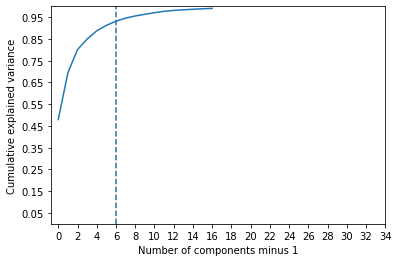

In [26]:
# do a PCA and look at the cumulative variance plot
pca = PCA(n_components = .99, svd_solver = 'full')
pca.fit(data_zs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components minus 1')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 36, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1)

In [27]:
# now redo the PCA but just keep the top few PCs
data_zs = data_zs_save.copy()
pca = PCA(n_components = 7, svd_solver = 'full')
princ_comps = pca.fit_transform(data_zs)
pca.n_components_

7

In [28]:
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca_zs = (data_pca - data_pca.mean()) / data_pca.std()
data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,0.167056,-0.813776,0.300969,0.697075,0.456185,-0.112215,0.550215
1,0.787197,-1.692722,0.166116,1.003552,0.521750,-0.205772,0.615583
2,2.067207,-3.541687,-0.364382,1.862413,0.383035,-0.559110,-0.006407
3,-0.868590,0.654080,0.526177,0.185254,0.346692,0.044028,0.441052
4,-0.407379,0.000389,0.425884,0.413187,0.395453,-0.025552,0.489667


In [29]:
## z-score outlier by euclidean distance.
p1=2
oop1 = 1/p1
score1 = (((data_pca_zs).abs()**p1).sum(axis=1))**oop1
score1

0         0.890153
1         1.193789
2         1.864964
3         0.669417
4         0.700967
            ...   
982785    0.114205
982786    0.114205
982787    0.232521
982788    0.232521
982789    0.232521
Length: 982790, dtype: float64

In [30]:
Automodel = MLPRegressor(hidden_layer_sizes= (10), activation= 'relu', verbose= True, max_iter= 15, random_state= 1)
Automodel.fit(data_pca_zs, data_pca_zs)

Iteration 1, loss = 0.44752054
Iteration 2, loss = 0.25726529
Iteration 3, loss = 0.14643966
Iteration 4, loss = 0.07174205
Iteration 5, loss = 0.04189183
Iteration 6, loss = 0.02883061
Iteration 7, loss = 0.01910306
Iteration 8, loss = 0.01411069
Iteration 9, loss = 0.00891802
Iteration 10, loss = 0.00713296
Iteration 11, loss = 0.00642229
Iteration 12, loss = 0.00441177
Iteration 13, loss = 0.00403585
Iteration 14, loss = 0.00395314
Iteration 15, loss = 0.00232094


/Users/sky/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=10, max_iter=15, random_state=1, verbose=True)

In [31]:
pca_output = Automodel.predict(data_pca_zs)
error_model = pca_output - data_pca_zs
p2=2
oop2 = 1/p2
score2 = ((error_model.abs() ** p2).sum(axis= 1))**oop2

In [32]:
scores = pd.DataFrame(score1)
scores.columns=['score1']
scores['score2'] = score2
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()
scores['final'] = (.5*scores['score1 rank'] + .5*scores['score2 rank'])
top_records = scores.sort_values(['final'], ascending = False).head(1000).index

In [33]:
scores['rank1'] = scores['score1'].rank(method = 'max', ascending = False)
scores['rank2'] = scores['score2'].rank(method = 'max', ascending = False)
scores['final_rank'] = scores['final'].rank(method = 'max', ascending = False)
top_index = scores.sort_values(['final_rank'], ascending = True).head(800).index

In [34]:
result_table = data_zs.iloc[top_index]

In [38]:
result2 = scores.iloc[top_index]
result2.head(30)  ## Top 30 Fraud Encounter NY Property

,score1,score2,score1 rank,score2 rank,final,rank1,rank2,final_rank
859448,954.096294,166.505708,982790.0,982790.0,982790.0,1.0,1.0,1.0
59079,894.507829,114.457464,982789.0,982789.0,982789.0,2.0,2.0,2.0
9650,372.049838,24.775014,982785.0,982786.0,982785.5,6.0,5.0,3.0
94658,359.947081,19.847680,982783.0,982782.0,982782.5,8.0,9.0,5.0
631798,445.709044,16.733993,982788.0,982777.0,982782.5,3.0,14.0,5.0
560265,372.251606,16.757163,982786.0,982778.0,982782.0,5.0,13.0,7.0
874332,281.177660,27.006900,982777.0,982787.0,982782.0,14.0,4.0,7.0
295050,262.464304,36.656269,982773.0,982788.0,982780.5,18.0,3.0,8.0
612750,332.076755,18.118799,982780.0,982780.0,982780.0,11.0,11.0,9.0
912744,322.876258,16.173814,982779.0,982775.0,982777.0,12.0,16.0,10.0
